# Player Disruption Metric
This notebook calculates a disruption score for players based on StatsBomb event data.
- Focus: passes and carries that generate reactive defender movements
- Goal: identify players who cause chaos beyond xG or assists

Men’s World Cup 2018

UEFA Champions League (select seasons)

La Liga (2017–2021, select matches)

Serie A (2015/16 season, like Carpi vs Verona)

Women’s FA Super League

Youth/International tournaments (e.g., U20 World Cup, African Cup of Nations)



In [9]:
import sys
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

script_path = Path("../scripts").resolve()
if str(script_path) not in sys.path:
    sys.path.append(str(script_path))

from load_statsbomb import load_match_events, load_player_minutes_and_positions

%matplotlib inline


In [11]:
world_cup_ids = {
    "7525", "7529", "7530", "7531", "7532", "7533", "7534", "7535", "7536", "7537",
    "7538", "7539", "7540", "7541", "7542", "7543", "7544", "7545", "7546", "7547",
    "7548", "7549", "7550", "7551", "7552", "7553", "7554", "7555", "7556", "7557",
    "7558", "7559", "7560", "7561", "7562", "7563", "7564", "7565", "7566", "7567",
    "7568", "7569", "7570", "7571", "7572", "7576", "7577", "7578", "7579", "7580",
    "7581", "7582", "7583", "7584", "7585", "7586", "8649", "8650", "8651", "8652",
    "8653", "8654", "8655", "8656", "8657", "8658"
}
events_dir = "../data/statsbomb-open-data/events"
lineups_dir = "../data/statsbomb-open-data/lineups"
available_event_ids = [
    p.stem for p in Path(events_dir).glob("*.json")
    if p.stem in world_cup_ids
]
print(f"Using {len(available_event_ids)} World Cup matches.")

Using 64 World Cup matches.


In [12]:
minutes_df = load_player_minutes_and_positions(lineups_dir, available_event_ids)

In [13]:
from collections import defaultdict

player_totals = defaultdict(lambda: {"team": None, "total_actions": 0, "total_disruption": 0})

for match_id in available_event_ids:
    df = load_match_events(events_dir, match_id)
    actions = df[df["type.name"].isin(["Pass", "Carry"])].sort_values(by="index").reset_index(drop=True)

    for i, action in actions.iterrows():
        try:
            action_time = pd.to_timedelta(action["timestamp"])
            team = action["team.name"]
            player = action["player.name"]
        except:
            continue

        lookahead = df.iloc[i+1:i+21]
        pressure_count = sum(
            1 for _, e in lookahead.iterrows()
            if e["type.name"] == "Pressure"
            and pd.to_timedelta(e["timestamp"]) - action_time <= pd.to_timedelta("00:00:02")
            and e["team.name"] != team
        )
        player_totals[player]["team"] = team
        player_totals[player]["total_actions"] += 1
        player_totals[player]["total_disruption"] += pressure_count

player_scores = pd.DataFrame([
    {
        "player": p,
        "team": data["team"],
        "total_actions": data["total_actions"],
        "total_disruption": data["total_disruption"],
        "avg_disruption": data["total_disruption"] / data["total_actions"] if data["total_actions"] else 0
    }
    for p, data in player_totals.items()
])



In [14]:
player_scores = player_scores[player_scores["total_actions"] >= 50]

In [15]:
player_scores.sort_values("avg_disruption", ascending=False).head(10)

,player,team,total_actions,total_disruption,avg_disruption
81,Sami Khedira,Germany,188,303,1.611702
157,Franco Armani,Argentina,69,100,1.449275
578,Amine Harit,Morocco,69,91,1.318841
556,Niklas Süle,Germany,163,209,1.282209
593,Oscar Fabián Murillo Murillo,Colombia,71,89,1.253521
165,Enzo Nicolás Pérez,Argentina,222,276,1.243243
161,Gabriel Iván Mercado,Argentina,334,402,1.203593
94,Mats Hummels,Germany,181,213,1.176796
585,Tin Jedvaj,Croatia,84,97,1.154762
447,Kenneth Josiah Omeruo,Nigeria,128,143,1.117188


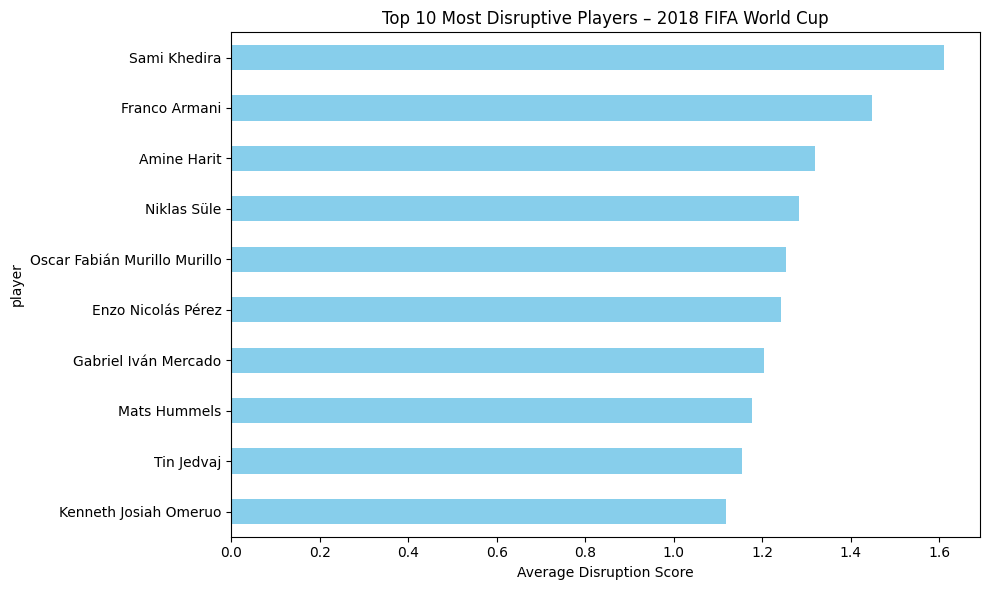

In [16]:
top10 = player_scores.sort_values("avg_disruption", ascending=False).head(10)
top10.plot.barh(x="player", y="avg_disruption", legend=False, figsize=(10, 6), color="skyblue")
plt.xlabel("Average Disruption Score")
plt.title("Top 10 Most Disruptive Players – 2018 FIFA World Cup")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Interestingly, this list is dominated by defensive midfielders and center backs — players like Sami Khedira, Niklas Süle, and Mats Hummels.
These players often operate in high-pressure zones, attract early pressure, and have high pass volumes.
While they aren’t flashy attackers, they consistently trigger reactions that break an opponent’s shape — which is exactly what our metric is trying to capture.

This also shows that disruption isn’t just about creative players — it’s about tactical roles.
Khedira and Mercado were often targeted by pressing teams, and the way they managed or absorbed that pressure helped dictate the flow of play.